<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_DAE_3_SSIM_loss_combined_plz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모듈 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import pandas as pd
import torchaudio
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

## 라벨링 및 데이터셋 로더
+ global scaling STFT 적용

In [ ]:
#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

In [ ]:
#######################
# 2. Feature Extraction & Augmentation
#######################
# 계산된 전역 평균과 표준편차
GLOBAL_MEAN =  -6.191081653188225
GLOBAL_STD = 12.042716979980469

def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    """
    WAV 파일을 STFT 기반 로그 스펙트럼으로 변환.
    - torchaudio.transforms.Spectrogram로 STFT 계산
    - AmplitudeToDB로 로그 변환 후 global standard scaling 적용 **
    """
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)

    # 전체 데이터셋의 평균과 표준편차로 정규화 적용
    log_spec = (log_spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-9)
    return log_spec


def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.1)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.05))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.05))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

from typing import Tuple, List
from torch.utils.data import DataLoader

#############################
# DataLoader 관련 함수들
#############################

def get_train_loader(args, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if f.endswith('.wav')]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft,
                                 win_length=args.win_length, hop_length=args.hop_length,
                                 power=args.power, augment=True)
    return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

def get_eval_loader(args, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list if f.endswith('.wav')]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft,
                                 win_length=args.win_length, hop_length=args.hop_length,
                                 power=args.power, augment=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    return loader, file_list

## 모델 학습 및 평가

In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
# pip install pytorch-msssim
from pytorch_msssim import ssim

#############################
# SSIM Loss Implementation
#############################
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, data_range=1.0, K=(0.01, 0.03)):
        """
        SSIMLoss는 pytorch_msssim의 ssim 함수를 이용하여,
        두 이미지 간의 구조적 유사성을 평가합니다.
        """
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.data_range = data_range
        self.K = K

    def forward(self, img1, img2):
        # ssim 값은 1에 가까울수록 유사하므로, loss는 1 - ssim으로 정의
        return 1 - ssim(img1, img2, data_range=self.data_range, win_size=self.window_size, size_average=self.size_average, K=self.K)

#############################
# Combined Loss (SSIM + L1)
#############################
class CombinedLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2):
        """
        SSIM과 L1 손실을 결합합니다.
          - window_size: SSIM 계산 시 윈도우 크기
          - size_average: 손실 산출 시 평균 사용 여부
          - ssim_weight: SSIM 손실의 가중치
          - l1_weight: L1 손실의 가중치
        """
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIMLoss(window_size, size_average)
        self.ssim_weight = ssim_weight
        self.l1_weight = l1_weight

    def forward(self, img1, img2):
        loss_ssim = self.ssim_loss(img1, img2)
        loss_l1 = F.l1_loss(img1, img2)
        return self.ssim_weight * loss_ssim + self.l1_weight * loss_l1

#############################
# Utility: 크기 맞춤 함수
#############################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#############################
# Model Architecture (DAE)
#############################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.03):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)

    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.03):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

    def forward(self, x):
        e1 = self.enc1(x)   # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

#############################
# Train & Evaluate 관련 함수들
#############################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_combined_plz.pth",
        "epochs": 200,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 1,
        "early_stopping_patience": 20,
        "noise_factor": 0.2,
        "dropout": 0.05,
        # 누락된 속성 추가
        "sr": 16000,  # 샘플링 레이트
        "n_fft": 2048, # FFT 크기
        "win_length": 512, # 윈도우 길이
        "hop_length": 256, # 홉 길이
        "power": 2.0 # STFT 계산에 사용할 power 값
    }
    parser = argparse.ArgumentParser()
    for key, value in param.items():
        parser.add_argument(f"--{key.replace('_','-')}", default=value, type=type(value))
    args, unknown = parser.parse_known_args()
    return args

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_and_evaluate(args: argparse.Namespace) -> None:
    print("Training started...")
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    set_seed(2025)

    # 단, 재현성이 중요하다면 benchmark 옵션을 끄는 것을 고려하세요.
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    model = DAEModel(args.dropout).to(device)

    try:
        from torchsummary import summary
        summary(model, input_size=(1, 256, 256))
    except ImportError:
        print(model)

    # 데이터 로더 함수들은 외부에 구현되어 있다고 가정합니다.
    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)
    val_loader, _ = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    # CombinedLoss를 손실 함수로 사용 (SSIM + L1)
    criterion = CombinedLoss(window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2)

    train_losses = []
    val_losses = []
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, args.epochs+1):
        model.train()
        total_loss = 0.0
        count = 0
        p_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{args.epochs}", ncols=100)
        for data in p_bar:
            spec = data[0].to(device)
            noisy_spec = spec + args.noise_factor * torch.randn_like(spec)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                decoded = model(noisy_spec)
                loss = criterion(decoded, spec)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            count += 1
            p_bar.set_description(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        avg_train_loss = total_loss / count
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch} average train loss: {avg_train_loss:.4f}")

        model.eval()
        total_val_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for val_data in val_loader:
                spec, anomaly_label, _, _ = val_data
                spec = spec.to(device)
                decoded = model(spec)
                loss = criterion(decoded, spec)
                total_val_loss += loss.item()
                val_count += 1
        avg_val_loss = total_val_loss / val_count
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch} average val loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            checkpoint_path = os.path.join(args.model_dir, args.model_path)
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Epoch {epoch}: Model improved. Saved checkpoint to {checkpoint_path}")
        else:
            patience_counter += 1
            if patience_counter >= args.early_stopping_patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # 학습 곡선 그리기 및 저장
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Combined Loss (SSIM + L1)')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    curve_path = os.path.join(args.result_dir, "learning_curve.png")
    plt.savefig(curve_path)
    plt.show()
    print(f"Learning curve saved to {curve_path}")

    # 최종 평가: 각 샘플별 손실을 기반으로 anomaly score 계산
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            spec, anomaly_label, _, _ = val_data
            spec = spec.to(device)
            decoded = model(spec)
            loss = criterion(decoded, spec)
            y_pred.append(loss.item())
            # anomaly_label이 텐서일 경우 scalar 값으로 변환
            y_true.append(anomaly_label.item() if anomaly_label.dim() == 0 else anomaly_label.cpu().numpy()[0])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    pr_auc = metrics.average_precision_score(y_true, y_pred)
    print(f"Evaluation AUC: {pr_auc:.4f}")

    # 결과 저장 (파일 이름 등은 필요에 따라 추가하세요)
    import pandas as pd
    results = []  # 테스트 결과 저장 리스트 (필요시 수정)
    df_results = pd.DataFrame(results, columns=["File Name", "Anomaly Label", "Loss"])
    csv_file_path = os.path.join(args.result_dir, "test_results_combined_plz.csv")
    df_results.to_csv(csv_file_path, index=False)
    print(f"Test results saved to {csv_file_path}")

<ipython-input-49-a15c29a4060a>:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training started...
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             320
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
           Dropout-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,248
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
    ResidualBlock-10         [-1, 32, 128, 128]               0
     EncoderBlock-11         [-1, 32, 128, 128]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128


Epoch 1/200:   0%|                                                          | 0/169 [00:00<?, ?it/s]<ipython-input-49-a15c29a4060a>:248: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1, Loss: 0.5664: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 1 average train loss: 0.6759


Epoch 1 average val loss: 0.5112
Epoch 1: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 2, Loss: 0.4447: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 2 average train loss: 0.4824


Epoch 2 average val loss: 0.4331
Epoch 2: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 3, Loss: 0.4252: 100%|██████████████████████████████████████| 169/169 [00:48<00:00,  3.52it/s]

Epoch 3 average train loss: 0.4101


Epoch 3 average val loss: 0.3481
Epoch 3: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 4, Loss: 0.3760: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 4 average train loss: 0.3779


Epoch 4 average val loss: 0.3368
Epoch 4: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 5, Loss: 0.3919: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 5 average train loss: 0.3608


Epoch 5 average val loss: 0.3149
Epoch 5: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 6, Loss: 0.3425: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 6 average train loss: 0.3459


Epoch 6 average val loss: 0.3011
Epoch 6: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 7, Loss: 0.3333: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.52it/s]

Epoch 7 average train loss: 0.3332


Epoch 7 average val loss: 0.2892
Epoch 7: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 8, Loss: 0.3142: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 8 average train loss: 0.3263


Epoch 8 average val loss: 0.3031


Epoch 9, Loss: 0.3090: 100%|██████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 9 average train loss: 0.3149


Epoch 9 average val loss: 0.2626
Epoch 9: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 10, Loss: 0.3644: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 10 average train loss: 0.3156


Epoch 10 average val loss: 0.2821


Epoch 11, Loss: 0.3107: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 11 average train loss: 0.3048


Epoch 11 average val loss: 0.2477
Epoch 11: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 12, Loss: 0.2989: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 12 average train loss: 0.3000


Epoch 12 average val loss: 0.2955


Epoch 13, Loss: 0.2912: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 13 average train loss: 0.2959


Epoch 13 average val loss: 0.2531


Epoch 14, Loss: 0.2995: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 14 average train loss: 0.2922


Epoch 14 average val loss: 0.2386
Epoch 14: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 15, Loss: 0.3329: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 15 average train loss: 0.2805


Epoch 15 average val loss: 0.2411


Epoch 16, Loss: 0.3012: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.52it/s]

Epoch 16 average train loss: 0.2841


Epoch 16 average val loss: 0.2497


Epoch 17, Loss: 0.2467: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 17 average train loss: 0.2799


Epoch 17 average val loss: 0.2442


Epoch 18, Loss: 0.2346: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 18 average train loss: 0.2658


Epoch 18 average val loss: 0.2212
Epoch 18: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 19, Loss: 0.2890: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 19 average train loss: 0.2699


Epoch 19 average val loss: 0.2493


Epoch 20, Loss: 0.2478: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 20 average train loss: 0.2712


Epoch 20 average val loss: 0.2326


Epoch 21, Loss: 0.2372: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 21 average train loss: 0.2639


Epoch 21 average val loss: 0.2271


Epoch 22, Loss: 0.2725: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 22 average train loss: 0.2647


Epoch 22 average val loss: 0.2158
Epoch 22: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 23, Loss: 0.2476: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 23 average train loss: 0.2647


Epoch 23 average val loss: 0.2159


Epoch 24, Loss: 0.3513: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 24 average train loss: 0.2622


Epoch 24 average val loss: 0.2656


Epoch 25, Loss: 0.2316: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 25 average train loss: 0.2573


Epoch 25 average val loss: 0.2218


Epoch 26, Loss: 0.2281: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 26 average train loss: 0.2569


Epoch 26 average val loss: 0.2140
Epoch 26: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 27, Loss: 0.2777: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 27 average train loss: 0.2463


Epoch 27 average val loss: 0.2231


Epoch 28, Loss: 0.2957: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]

Epoch 28 average train loss: 0.2411


Epoch 28 average val loss: 0.2033
Epoch 28: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 29, Loss: 0.2309: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 29 average train loss: 0.2390


Epoch 29 average val loss: 0.2043


Epoch 30, Loss: 0.2328: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 30 average train loss: 0.2411


Epoch 30 average val loss: 0.2063


Epoch 31, Loss: 0.2175: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 31 average train loss: 0.2374


Epoch 31 average val loss: 0.1944
Epoch 31: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 32, Loss: 0.2157: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 32 average train loss: 0.2323


Epoch 32 average val loss: 0.2166


Epoch 33, Loss: 0.2062: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 33 average train loss: 0.2342


Epoch 33 average val loss: 0.1981


Epoch 34, Loss: 0.2053: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 34 average train loss: 0.2321


Epoch 34 average val loss: 0.2079


Epoch 35, Loss: 0.2167: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 35 average train loss: 0.2302


Epoch 35 average val loss: 0.1996


Epoch 36, Loss: 0.2273: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 36 average train loss: 0.2327


Epoch 36 average val loss: 0.2186


Epoch 37, Loss: 0.2731: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 37 average train loss: 0.2269


Epoch 37 average val loss: 0.1917
Epoch 37: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 38, Loss: 0.2066: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 38 average train loss: 0.2282


Epoch 38 average val loss: 0.1881
Epoch 38: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 39, Loss: 0.2106: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 39 average train loss: 0.2222


Epoch 39 average val loss: 0.1922


Epoch 40, Loss: 0.1992: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 40 average train loss: 0.2177


Epoch 40 average val loss: 0.1829
Epoch 40: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 41, Loss: 0.2297: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 41 average train loss: 0.2216


Epoch 41 average val loss: 0.1920


Epoch 42, Loss: 0.1898: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 42 average train loss: 0.2184


Epoch 42 average val loss: 0.1863


Epoch 43, Loss: 0.2110: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 43 average train loss: 0.2205


Epoch 43 average val loss: 0.1823
Epoch 43: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 44, Loss: 0.2247: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 44 average train loss: 0.2136


Epoch 44 average val loss: 0.1908


Epoch 45, Loss: 0.2076: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 45 average train loss: 0.2152


Epoch 45 average val loss: 0.1868


Epoch 46, Loss: 0.2206: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 46 average train loss: 0.2153


Epoch 46 average val loss: 0.1772
Epoch 46: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 47, Loss: 0.1928: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 47 average train loss: 0.2123


Epoch 47 average val loss: 0.1827


Epoch 48, Loss: 0.1944: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 48 average train loss: 0.2104


Epoch 48 average val loss: 0.1786


Epoch 49, Loss: 0.2762: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 49 average train loss: 0.2109


Epoch 49 average val loss: 0.1856


Epoch 50, Loss: 0.1969: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 50 average train loss: 0.2098


Epoch 50 average val loss: 0.1936


Epoch 51, Loss: 0.3694: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 51 average train loss: 0.2131


Epoch 51 average val loss: 0.2062


Epoch 52, Loss: 0.1949: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 52 average train loss: 0.2100


Epoch 52 average val loss: 0.1860


Epoch 53, Loss: 0.2988: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 53 average train loss: 0.2119


Epoch 53 average val loss: 0.1955


Epoch 54, Loss: 0.1869: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 54 average train loss: 0.2082


Epoch 54 average val loss: 0.1755
Epoch 54: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 55, Loss: 0.1873: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 55 average train loss: 0.2078


Epoch 55 average val loss: 0.1784


Epoch 56, Loss: 0.1803: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 56 average train loss: 0.2087


Epoch 56 average val loss: 0.1745
Epoch 56: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 57, Loss: 0.1779: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 57 average train loss: 0.2014


Epoch 57 average val loss: 0.1666
Epoch 57: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 58, Loss: 0.2509: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 58 average train loss: 0.2066


Epoch 58 average val loss: 0.1739


Epoch 59, Loss: 0.1773: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 59 average train loss: 0.2057


Epoch 59 average val loss: 0.1779


Epoch 60, Loss: 0.1839: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 60 average train loss: 0.2143


Epoch 60 average val loss: 0.1807


Epoch 61, Loss: 0.2394: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 61 average train loss: 0.1967


Epoch 61 average val loss: 0.1683


Epoch 62, Loss: 0.2017: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 62 average train loss: 0.2010


Epoch 62 average val loss: 0.1738


Epoch 63, Loss: 0.2294: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 63 average train loss: 0.2047


Epoch 63 average val loss: 0.2090


Epoch 64, Loss: 0.1969: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 64 average train loss: 0.2108


Epoch 64 average val loss: 0.1824


Epoch 65, Loss: 0.1826: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 65 average train loss: 0.2000


Epoch 65 average val loss: 0.1745


Epoch 66, Loss: 0.3080: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 66 average train loss: 0.2020


Epoch 66 average val loss: 0.1691


Epoch 67, Loss: 0.2821: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 67 average train loss: 0.2011


Epoch 67 average val loss: 0.1912


Epoch 68, Loss: 0.1901: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 68 average train loss: 0.1986


Epoch 68 average val loss: 0.1629
Epoch 68: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 69, Loss: 0.2653: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 69 average train loss: 0.1961


Epoch 69 average val loss: 0.1670


Epoch 70, Loss: 0.1926: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 70 average train loss: 0.1974


Epoch 70 average val loss: 0.1642


Epoch 71, Loss: 0.1944: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 71 average train loss: 0.1942


Epoch 71 average val loss: 0.1664


Epoch 72, Loss: 0.2757: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 72 average train loss: 0.1938


Epoch 72 average val loss: 0.1708


Epoch 73, Loss: 0.1793: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 73 average train loss: 0.1877


Epoch 73 average val loss: 0.1688


Epoch 74, Loss: 0.1852: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 74 average train loss: 0.1985


Epoch 74 average val loss: 0.1855


Epoch 75, Loss: 0.1748: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 75 average train loss: 0.1900


Epoch 75 average val loss: 0.1669


Epoch 76, Loss: 0.2238: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 76 average train loss: 0.1911


Epoch 76 average val loss: 0.1588
Epoch 76: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 77, Loss: 0.1754: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 77 average train loss: 0.1925


Epoch 77 average val loss: 0.1638


Epoch 78, Loss: 0.1973: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 78 average train loss: 0.1897


Epoch 78 average val loss: 0.1577
Epoch 78: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 79, Loss: 0.2582: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 79 average train loss: 0.1902


Epoch 79 average val loss: 0.1625


Epoch 80, Loss: 0.1940: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 80 average train loss: 0.1856


Epoch 80 average val loss: 0.1682


Epoch 81, Loss: 0.1624: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 81 average train loss: 0.1902


Epoch 81 average val loss: 0.1560
Epoch 81: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 82, Loss: 0.1878: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 82 average train loss: 0.1879


Epoch 82 average val loss: 0.1626


Epoch 83, Loss: 0.1860: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 83 average train loss: 0.1931


Epoch 83 average val loss: 0.1637


Epoch 84, Loss: 0.1599: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 84 average train loss: 0.1869


Epoch 84 average val loss: 0.1599


Epoch 85, Loss: 0.2109: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 85 average train loss: 0.1852


Epoch 85 average val loss: 0.1568


Epoch 86, Loss: 0.1877: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 86 average train loss: 0.1871


Epoch 86 average val loss: 0.1582


Epoch 87, Loss: 0.2304: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 87 average train loss: 0.1852


Epoch 87 average val loss: 0.1590


Epoch 88, Loss: 0.1618: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 88 average train loss: 0.1820


Epoch 88 average val loss: 0.1595


Epoch 89, Loss: 0.1793: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 89 average train loss: 0.1787


Epoch 89 average val loss: 0.1715


Epoch 90, Loss: 0.1864: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 90 average train loss: 0.1773


Epoch 90 average val loss: 0.1584


Epoch 91, Loss: 0.1633: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 91 average train loss: 0.1711


Epoch 91 average val loss: 0.1518
Epoch 91: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 92, Loss: 0.1570: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 92 average train loss: 0.1703


Epoch 92 average val loss: 0.1517
Epoch 92: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 93, Loss: 0.1722: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 93 average train loss: 0.1714


Epoch 93 average val loss: 0.1511
Epoch 93: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 94, Loss: 0.1660: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 94 average train loss: 0.1678


Epoch 94 average val loss: 0.1579


Epoch 95, Loss: 0.1628: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 95 average train loss: 0.1633


Epoch 95 average val loss: 0.1573


Epoch 96, Loss: 0.1947: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 96 average train loss: 0.1633


Epoch 96 average val loss: 0.1575


Epoch 97, Loss: 0.1537: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 97 average train loss: 0.1608


Epoch 97 average val loss: 0.1597


Epoch 98, Loss: 0.1604: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 98 average train loss: 0.1589


Epoch 98 average val loss: 0.1578


Epoch 99, Loss: 0.1647: 100%|█████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 99 average train loss: 0.1589


Epoch 99 average val loss: 0.1619


Epoch 100, Loss: 0.1503: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 100 average train loss: 0.1594


Epoch 100 average val loss: 0.1496
Epoch 100: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 101, Loss: 0.1528: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 101 average train loss: 0.1596


Epoch 101 average val loss: 0.1595


Epoch 102, Loss: 0.1624: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 102 average train loss: 0.1588


Epoch 102 average val loss: 0.1498


Epoch 103, Loss: 0.1708: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 103 average train loss: 0.1576


Epoch 103 average val loss: 0.1562


Epoch 104, Loss: 0.1603: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 104 average train loss: 0.1595


Epoch 104 average val loss: 0.1624


Epoch 105, Loss: 0.1569: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 105 average train loss: 0.1576


Epoch 105 average val loss: 0.1535


Epoch 106, Loss: 0.1555: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 106 average train loss: 0.1558


Epoch 106 average val loss: 0.1488
Epoch 106: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 107, Loss: 0.1503: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 107 average train loss: 0.1571


Epoch 107 average val loss: 0.1495


Epoch 108, Loss: 0.1610: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 108 average train loss: 0.1556


Epoch 108 average val loss: 0.1490


Epoch 109, Loss: 0.1554: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 109 average train loss: 0.1538


Epoch 109 average val loss: 0.1476
Epoch 109: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 110, Loss: 0.1553: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 110 average train loss: 0.1536


Epoch 110 average val loss: 0.1552


Epoch 111, Loss: 0.1513: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 111 average train loss: 0.1535


Epoch 111 average val loss: 0.1465
Epoch 111: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 112, Loss: 0.1530: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 112 average train loss: 0.1540


Epoch 112 average val loss: 0.1448
Epoch 112: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 113, Loss: 0.1495: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 113 average train loss: 0.1521


Epoch 113 average val loss: 0.1474


Epoch 114, Loss: 0.1510: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 114 average train loss: 0.1529


Epoch 114 average val loss: 0.1490


Epoch 115, Loss: 0.1579: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 115 average train loss: 0.1542


Epoch 115 average val loss: 0.1526


Epoch 116, Loss: 0.1498: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 116 average train loss: 0.1536


Epoch 116 average val loss: 0.1479


Epoch 117, Loss: 0.1735: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 117 average train loss: 0.1523


Epoch 117 average val loss: 0.1743


Epoch 118, Loss: 0.1581: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 118 average train loss: 0.1538


Epoch 118 average val loss: 0.1473


Epoch 119, Loss: 0.1505: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 119 average train loss: 0.1517


Epoch 119 average val loss: 0.1517


Epoch 120, Loss: 0.1455: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 120 average train loss: 0.1497


Epoch 120 average val loss: 0.1439
Epoch 120: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 121, Loss: 0.1548: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 121 average train loss: 0.1500


Epoch 121 average val loss: 0.1479


Epoch 122, Loss: 0.1547: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 122 average train loss: 0.1496


Epoch 122 average val loss: 0.1459


Epoch 123, Loss: 0.1616: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 123 average train loss: 0.1530


Epoch 123 average val loss: 0.1502


Epoch 124, Loss: 0.1582: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 124 average train loss: 0.1501


Epoch 124 average val loss: 0.1498


Epoch 125, Loss: 0.1490: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 125 average train loss: 0.1492


Epoch 125 average val loss: 0.1434
Epoch 125: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 126, Loss: 0.1432: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 126 average train loss: 0.1484


Epoch 126 average val loss: 0.1440


Epoch 127, Loss: 0.1443: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 127 average train loss: 0.1479


Epoch 127 average val loss: 0.1421
Epoch 127: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 128, Loss: 0.1433: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 128 average train loss: 0.1587


Epoch 128 average val loss: 0.1443


Epoch 129, Loss: 0.1455: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 129 average train loss: 0.1491


Epoch 129 average val loss: 0.1456


Epoch 130, Loss: 0.1490: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 130 average train loss: 0.1476


Epoch 130 average val loss: 0.1431


Epoch 131, Loss: 0.1478: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 131 average train loss: 0.1486


Epoch 131 average val loss: 0.1436


Epoch 132, Loss: 0.1474: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 132 average train loss: 0.1478


Epoch 132 average val loss: 0.1426


Epoch 133, Loss: 0.1579: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 133 average train loss: 0.1476


Epoch 133 average val loss: 0.1418
Epoch 133: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 134, Loss: 0.1492: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 134 average train loss: 0.1475


Epoch 134 average val loss: 0.1418


Epoch 135, Loss: 0.1514: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 135 average train loss: 0.1479


Epoch 135 average val loss: 0.1434


Epoch 136, Loss: 0.1516: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 136 average train loss: 0.1480


Epoch 136 average val loss: 0.1418
Epoch 136: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 137, Loss: 0.1448: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 137 average train loss: 0.1461


Epoch 137 average val loss: 0.1416
Epoch 137: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 138, Loss: 0.1533: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 138 average train loss: 0.1478


Epoch 138 average val loss: 0.1414
Epoch 138: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 139, Loss: 0.1507: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 139 average train loss: 0.1503


Epoch 139 average val loss: 0.1515


Epoch 140, Loss: 0.1434: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 140 average train loss: 0.1473


Epoch 140 average val loss: 0.1462


Epoch 141, Loss: 0.1511: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 141 average train loss: 0.1465


Epoch 141 average val loss: 0.1425


Epoch 142, Loss: 0.1427: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 142 average train loss: 0.1462


Epoch 142 average val loss: 0.1405
Epoch 142: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 143, Loss: 0.1434: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 143 average train loss: 0.1456


Epoch 143 average val loss: 0.1415


Epoch 144, Loss: 0.1464: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 144 average train loss: 0.1463


Epoch 144 average val loss: 0.1401
Epoch 144: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 145, Loss: 0.1425: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 145 average train loss: 0.1447


Epoch 145 average val loss: 0.1406


Epoch 146, Loss: 0.1390: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 146 average train loss: 0.1445


Epoch 146 average val loss: 0.1391
Epoch 146: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 147, Loss: 0.1466: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 147 average train loss: 0.1459


Epoch 147 average val loss: 0.1395


Epoch 148, Loss: 0.1371: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 148 average train loss: 0.1449


Epoch 148 average val loss: 0.1401


Epoch 149, Loss: 0.1402: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]

Epoch 149 average train loss: 0.1452


Epoch 149 average val loss: 0.1401


Epoch 150, Loss: 0.1428: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 150 average train loss: 0.1446


Epoch 150 average val loss: 0.1380
Epoch 150: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 151, Loss: 0.1466: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 151 average train loss: 0.1446


Epoch 151 average val loss: 0.1390


Epoch 152, Loss: 0.1592: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 152 average train loss: 0.1446


Epoch 152 average val loss: 0.1402


Epoch 153, Loss: 0.1531: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 153 average train loss: 0.1442


Epoch 153 average val loss: 0.1393


Epoch 154, Loss: 0.1418: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 154 average train loss: 0.1444


Epoch 154 average val loss: 0.1405


Epoch 155, Loss: 0.1474: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 155 average train loss: 0.1441


Epoch 155 average val loss: 0.1399


Epoch 156, Loss: 0.1510: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 156 average train loss: 0.1479


Epoch 156 average val loss: 0.1443


Epoch 157, Loss: 0.1437: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 157 average train loss: 0.1454


Epoch 157 average val loss: 0.1410


Epoch 158, Loss: 0.1593: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 158 average train loss: 0.1445


Epoch 158 average val loss: 0.1522


Epoch 159, Loss: 0.1406: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 159 average train loss: 0.1455


Epoch 159 average val loss: 0.1408


Epoch 160, Loss: 0.1427: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 160 average train loss: 0.1441


Epoch 160 average val loss: 0.1385


Epoch 161, Loss: 0.1389: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 161 average train loss: 0.1432


Epoch 161 average val loss: 0.1378
Epoch 161: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 162, Loss: 0.1391: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 162 average train loss: 0.1434


Epoch 162 average val loss: 0.1382


Epoch 163, Loss: 0.1438: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 163 average train loss: 0.1431


Epoch 163 average val loss: 0.1383


Epoch 164, Loss: 0.1435: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 164 average train loss: 0.1433


Epoch 164 average val loss: 0.1394


Epoch 165, Loss: 0.1385: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 165 average train loss: 0.1429


Epoch 165 average val loss: 0.1387


Epoch 166, Loss: 0.1472: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 166 average train loss: 0.1433


Epoch 166 average val loss: 0.1386


Epoch 167, Loss: 0.1424: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 167 average train loss: 0.1430


Epoch 167 average val loss: 0.1386


Epoch 168, Loss: 0.1393: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 168 average train loss: 0.1431


Epoch 168 average val loss: 0.1372
Epoch 168: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 169, Loss: 0.1441: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 169 average train loss: 0.1430


Epoch 169 average val loss: 0.1383


Epoch 170, Loss: 0.1426: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 170 average train loss: 0.1430


Epoch 170 average val loss: 0.1379


Epoch 171, Loss: 0.1438: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 171 average train loss: 0.1425


Epoch 171 average val loss: 0.1381


Epoch 172, Loss: 0.1463: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 172 average train loss: 0.1426


Epoch 172 average val loss: 0.1380


Epoch 173, Loss: 0.1489: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 173 average train loss: 0.1431


Epoch 173 average val loss: 0.1365
Epoch 173: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 174, Loss: 0.1410: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 174 average train loss: 0.1429


Epoch 174 average val loss: 0.1376


Epoch 175, Loss: 0.1453: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 175 average train loss: 0.1429


Epoch 175 average val loss: 0.1370


Epoch 176, Loss: 0.1479: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 176 average train loss: 0.1426


Epoch 176 average val loss: 0.1367


Epoch 177, Loss: 0.1464: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 177 average train loss: 0.1425


Epoch 177 average val loss: 0.1371


Epoch 178, Loss: 0.1431: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 178 average train loss: 0.1423


Epoch 178 average val loss: 0.1371


Epoch 179, Loss: 0.1492: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 179 average train loss: 0.1423


Epoch 179 average val loss: 0.1371


Epoch 180, Loss: 0.1426: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 180 average train loss: 0.1421


Epoch 180 average val loss: 0.1370


Epoch 181, Loss: 0.1412: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 181 average train loss: 0.1423


Epoch 181 average val loss: 0.1377


Epoch 182, Loss: 0.1439: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 182 average train loss: 0.1423


Epoch 182 average val loss: 0.1370


Epoch 183, Loss: 0.1522: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 183 average train loss: 0.1423


Epoch 183 average val loss: 0.1376


Epoch 184, Loss: 0.1417: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 184 average train loss: 0.1419


Epoch 184 average val loss: 0.1368


Epoch 185, Loss: 0.1444: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]

Epoch 185 average train loss: 0.1420


Epoch 185 average val loss: 0.1376


Epoch 186, Loss: 0.1428: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 186 average train loss: 0.1421


Epoch 186 average val loss: 0.1372


Epoch 187, Loss: 0.1447: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 187 average train loss: 0.1422


Epoch 187 average val loss: 0.1366


Epoch 188, Loss: 0.1395: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]

Epoch 188 average train loss: 0.1420


Epoch 188 average val loss: 0.1373


Epoch 189, Loss: 0.1447: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 189 average train loss: 0.1420


Epoch 189 average val loss: 0.1372


Epoch 190, Loss: 0.1398: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 190 average train loss: 0.1420


Epoch 190 average val loss: 0.1366


Epoch 191, Loss: 0.1468: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 191 average train loss: 0.1419


Epoch 191 average val loss: 0.1373


Epoch 192, Loss: 0.1387: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 192 average train loss: 0.1416


Epoch 192 average val loss: 0.1370


Epoch 193, Loss: 0.1368: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 193 average train loss: 0.1420


Epoch 193 average val loss: 0.1364
Epoch 193: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 194, Loss: 0.1379: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 194 average train loss: 0.1421


Epoch 194 average val loss: 0.1368


Epoch 195, Loss: 0.1494: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 195 average train loss: 0.1419


Epoch 195 average val loss: 0.1376


Epoch 196, Loss: 0.1397: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 196 average train loss: 0.1419


Epoch 196 average val loss: 0.1370


Epoch 197, Loss: 0.1462: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 197 average train loss: 0.1420


Epoch 197 average val loss: 0.1369


Epoch 198, Loss: 0.1508: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 198 average train loss: 0.1420


Epoch 198 average val loss: 0.1377


Epoch 199, Loss: 0.1477: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 199 average train loss: 0.1417


Epoch 199 average val loss: 0.1363
Epoch 199: Model improved. Saved checkpoint to /content/drive/MyDrive/model_dae_combined_plz.pth


Epoch 200, Loss: 0.1415: 100%|████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]

Epoch 200 average train loss: 0.1419


Epoch 200 average val loss: 0.1369


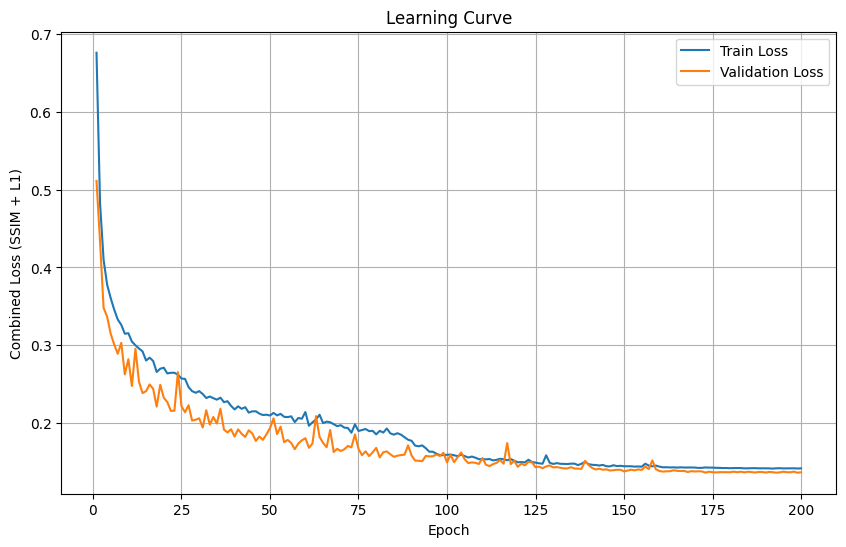

Learning curve saved to /content/drive/MyDrive/learning_curve.png
Evaluation AUC: 0.8493
Test results saved to /content/drive/MyDrive/test_results_combined_plz.csv


In [50]:
 if __name__ == "__main__":
    args = get_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    set_seed(2025)
    train_and_evaluate(args)

## 평가만 하는 코드

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

#############################
# SSIM Loss Implementation
#############################
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, data_range=1.0, K=(0.01, 0.03)):
        """
        SSIMLoss는 pytorch_msssim의 ssim 함수를 이용하여,
        두 이미지 간의 구조적 유사성을 평가합니다.
        """
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.data_range = data_range
        self.K = K

    def forward(self, img1, img2):
        # ssim 값이 1에 가까울수록 유사하므로, loss는 1 - ssim으로 정의
        return 1 - ssim(img1, img2, data_range=self.data_range,
                        win_size=self.window_size, size_average=self.size_average, K=self.K)

#############################
# Combined Loss (SSIM + L1)
#############################
class CombinedLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2):
        """
        SSIM과 L1 손실을 결합합니다.
          - window_size: SSIM 계산 시 윈도우 크기
          - size_average: 손실 산출 시 평균 사용 여부
          - ssim_weight: SSIM 손실의 가중치
          - l1_weight: L1 손실의 가중치
        """
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIMLoss(window_size, size_average)
        self.ssim_weight = ssim_weight
        self.l1_weight = l1_weight

    def forward(self, img1, img2):
        loss_ssim = self.ssim_loss(img1, img2)
        loss_l1 = F.l1_loss(img1, img2)
        return self.ssim_weight * loss_ssim + self.l1_weight * loss_l1

#############################
# Utility: 크기 맞춤 함수
#############################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#############################
# Model Architecture (DAE)
#############################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.03):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)

    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.03):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

    def forward(self, x):
        e1 = self.enc1(x)   # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

#############################
# Evaluation Dataset 및 Loader
#############################
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

class EvalDataset(Dataset):
    def __init__(self, file_list: List[str]):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(
            wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=256, power=2.0
        )
        # "anomaly"가 파일명에 포함되어 있으면 라벨 1, 아니면 0
        anomaly_label = 1 if "anomaly" in wav_path.lower() else 0
        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)
        return log_spec

def get_eval_loader(args, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list if f.endswith('.wav')]
    dataset = EvalDataset(file_list)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    return loader, file_list

#############################
# Argument 설정
#############################
def get_args() -> argparse.Namespace:
    param = {
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_combined_best.pth",
        "n_workers": 1,
        "dropout": 0.05
    }
    parser = argparse.ArgumentParser()
    for key, value in param.items():
        parser.add_argument(f"--{key.replace('_','-')}", default=value, type=type(value))
    args, unknown = parser.parse_known_args()
    return args

#############################
# 평가 함수 (모델 평가 및 CSV 저장, 평가만 수행)
#############################
def evaluate_model(args: argparse.Namespace) -> None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 불러오기 (저장된 checkpoint만 불러와 평가)
    model = DAEModel(args.dropout).to(device)
    checkpoint_path = os.path.join(args.model_dir, args.model_path)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    print(f"모델 가중치 로드 완료 from {checkpoint_path}")

    # 평가 데이터 로드
    eval_loader, file_list = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)
    criterion = CombinedLoss(window_size=11, size_average=True, ssim_weight=0.8, l1_weight=0.2)

    results = []
    y_true = []
    y_pred = []

    print("평가 진행 중...")
    with torch.no_grad():
        for idx, data in enumerate(eval_loader):
            spec, anomaly_label = data  # 두 개의 값만 언패킹
            spec = spec.to(device)
            decoded = model(spec)
            loss = criterion(decoded, spec).item()
            label = anomaly_label.item()  # 스칼라로 변환

            file_name = file_list[idx] if idx < len(file_list) else f"unknown_{idx}"
            results.append([file_name, label, loss])
            y_true.append(label)
            y_pred.append(loss)

    # PR-AUC 계산
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc_score = auc(recall, precision)
    print(f"Evaluation AUC: {pr_auc_score * 100:.2f}%")

    # CSV 파일로 평가 결과 저장
    os.makedirs(args.result_dir, exist_ok=True)
    csv_file_path = os.path.join(args.result_dir, "evaluation_results.csv")
    df_results = pd.DataFrame(results, columns=["File Name", "Anomaly Label", "Loss"])
    df_results.to_csv(csv_file_path, index=False)
    print(f"평가 결과가 CSV 파일로 저장되었습니다: {csv_file_path}")

#############################
# 메인 함수 (평가만 수행)
#############################
def main():
    args = get_args()
    evaluate_model(args)

if __name__ == "__main__":
    main()

Using device: cuda
모델 가중치 로드 완료 from /content/drive/MyDrive/model_dae_combined_best.pth
평가 진행 중...
Evaluation PR-AUC: 76.92%
평가 결과가 CSV 파일로 저장되었습니다: /content/drive/MyDrive/evaluation_results.csv


## 평가 데이터 바꿔서 모델 가중치 불러오기

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve
import torchaudio
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "path"

# 모델 생성 및 가중치 불러오기
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_combined.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=256, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

#######################
# 평가 지표 계산
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")
